<a href="https://colab.research.google.com/github/TechLabs-Dortmund/motion-miners/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import json
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from google.colab import drive # for running on Google Colab
drive.mount('/content/drive') # for running on Google Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
constant = {
    "region_flow_dict": {
        "region_name": [
            "Not in use",
            "Pre-checkin",
            "Waiting Checkin",
            "Checkin Main",
            "Waiting I",
            "Doctor Table",
            "Vaccination",
            "Waiting II",
            "Checkout",
            "Waiting III",
        ],
        "region_id": [
            1,
            [2, 5],
            90,
            [3, 4],
            91,
            [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
            [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
            92,
            [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
            93,
        ],
        "flow_id": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    },
    "txpower_vs_distance": {
        "Distance(m)": [0, 1, 3, 5, 10, 15, 20, 30, 40, 50],
        "-30(dBm)": [
            -63,
            -92,
            -99,
            -101,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
        ],
        "-20(dBm)": [-47, -79, -84, -90, -95, -98, -102, np.nan, np.nan, np.nan],
        "-16(dBm)": [-42, -71, -82, -88, -95, -97, -102, np.nan, np.nan, np.nan],
        "-12(dBm)": [-40, -68, -74, -84, -89, -95, -97, -102, np.nan, np.nan],
        "-8(dBm)": [-40, -66, -73, -82, -87, -92, -94, -96, -99, -102],
        "-4(dBm)": [-34, -58, -70, -74, -81, -90, -92, -93, -99, -102],
        "0(dBm)": [-27, -59, -67, -71, -79, -84, -87, -92, -94, -100],
        "4(dBm)": [-2, -57, -62, -67, -75, -82, -85, -88, -91, -99],
    },
};

In [140]:
def create_mapped_layout(layout_path):
    """
    Create a completed layout has beacons, regions and flows

    Parameters
    ----------
    layout_path: str
        path of layout file

    Returns
    -------
    pandas.DataFrame
        a dataframe of beacons, regions and flows
    """
    with open(layout_path, "r") as layout_file:
        layout = json.load(layout_file)
        beacons_layout = pd.DataFrame.from_dict(layout["beacons"])
        regions_layout = pd.DataFrame.from_dict(layout["regions"])

    beacons_regions_layout = beacons_layout.merge(
        regions_layout, left_on="region_uuid", right_on="uuid"
    )

    beacons_regions_layout.rename(
        columns={
            "id_x": "beacon_id",
            "id_y": "region_id",
            "name": "region_name",
            "position_x": "b_pos_x",
            "position_y": "b_pos_y",
            "position_top_left_x": "rpos_top_left_x",
            "position_top_left_y": "rpos_top_left_y",
            "position_bottom_right_x": "rpos_bottom_right_x",
            "position_bottom_right_y": "rpos_bottom_right_y",
        },
        inplace=True,
    )
    beacons_regions_layout["region_beacon"] = (
        beacons_regions_layout["region_id"].astype(str)
        + "_"
        + beacons_regions_layout["beacon_id"].astype(str)
    )

    region_flow_df = pd.DataFrame.from_dict(data=constant["region_flow_dict"])
    exploded_region_flow_df = region_flow_df.explode("region_id")

    final_layout = beacons_regions_layout.merge(
        exploded_region_flow_df, left_on="region_id", right_on="region_id"
    )
    final_layout["flow_beacon"] = (
        final_layout["flow_id"].astype(str)
        + "_"
        + final_layout["beacon_id"].astype(str)
    )

    return final_layout


def get_flow_of_beacon(layout):
    """
    Determine the flow id which beacon belongs to

    Parameters
    ----------
    layout: pandas.DataFrame
        the layout has mapped beacons, regions and flows

    Returns
    -------
    pandas.DataFrame
        a dataframe of beacons and its corresponding flow id
    """
    beacons_with_flow = layout.loc[
        :, ["beacon_id", "flow_id"]
    ]  # only the beacon and flow region ids are relevant here
    beacons_with_flow.sort_values(by=["flow_id", "beacon_id"], inplace=True)
    beacons_with_flow = beacons_with_flow[
        ["flow_id", "beacon_id"]
    ]  # change order of the columns

    return beacons_with_flow


def signal_to_m_converter(dataframe, dbm="4(dBm)"):
    """
    This function convert a (beacon)dataframe with signal values from the tracer
    to the corresponding *m*eter values, depend on dBm power that was used.
    By default dbm = 4(dBm)
    """
    # extract all different values from dataframe
    dataframe_unique_values = np.unique(dataframe)
    df_txpower = pd.DataFrame(constant.txpower_vs_distance)

    # extract the used power values from table_"Beacon_datasheet"
    choose_power = df_txpower[dbm]
    # caculate the lenght from powerlevel used for later iteration
    lenght_power = (df_txpower[dbm]).count()

    # empty list for collecting the corresponding meter values for each signal value
    list_meter_values = []
    flag = True
    # loop over unique_values over dataframe
    for value in dataframe_unique_values:
        # interpolation function
        for i in range(0, lenght_power):
            if choose_power[i] >= value and value >= choose_power[i + 1]:
                meter_value = (
                    df_txpower["Distance(m)"][i + 1] - df_txpower["Distance(m)"][i]
                ) / (choose_power[i + 1] - choose_power[i]) * (
                    value - choose_power[i]
                ) + df_txpower[
                    "Distance(m)"
                ][
                    i
                ]
                list_meter_values.append(meter_value)

                if flag:
                    print("\nDistance i+1", df_txpower["Distance(m)"][i + 1])
                    print("\nDistance i", df_txpower["Distance(m)"][i])
                    print("\nchoose_power i+1", choose_power[i + 1])
                    print("\nchoose_power i", choose_power[i])
                    print("\nvalue", value)
                    print("\ndf_txpower[distance][i]", df_txpower["Distance(m)"][i])
                    flag = False
                break
        else:
            meter_value = np.nan
            list_meter_values.append(meter_value)

    mod_dataframe = dataframe.replace(list(dataframe_unique_values), list_meter_values)
    return mod_dataframe


def extract_rssi_to_df(tracer_data_path):
    """
    Takes path from pickle file and create a df with a timeline and the rssi_arr values

    Parameters
    ----------
    tracer_data_path: str
        path to tracer data file

    Returns
    -------
    pandas.DataFrame
        tracer data
    """
    # create a dataframe df from the picke.file
    df_file = pickle.load(open(tracer_data_path, "rb"))

    # extract rssi_arr key to numpy.array
    rssi_arr = df_file["rssi_arr"]

    # set -inf equal to 0 (datacleaning)
    rssi_arr[rssi_arr == -np.Inf] = np.nan

    # figure out the shape from rssi_arr array for the timeline
    dim = np.shape(rssi_arr)

    # create a timeline and add it to the rssi_arr array
    # problem that it changes from 0091 file to others why?
    timeline = np.linspace(0.1, (dim[0]) * 0.1, dim[0]).reshape(dim[0], 1)
    mod_rssi_arr = np.append(rssi_arr, timeline, axis=1)

    # create the colum_names for df_rssi_arr (dataframe)
    # Beacon 252 does not exist
    # colum_names = []
    # for i in range(1, dim[1] + 2):
    #     if i == 52:
    #         continue
    #     else:
    #         value = "Beacon_" + str(200 + i)
    #         colum_names.append(value)
    # colum_names.append("timeline[s]")

    # beacon id as column
    colum_names = df_file["beacon_uuids"]
    colum_names = np.append(colum_names, "timeline[s]")

    # create df_rssi_arr
    df_rssi_arr = pd.DataFrame(data=mod_rssi_arr, columns=colum_names)
    df = df_rssi_arr.set_index("timeline[s]")

    return df


def add_flow_as_multi_index(tracer_df, beacon_flow):
    """
    Add flow id as second level column to tracer data

    Parameters
    ----------
    tracer_df: pandas.DataFrame
        tracer data
    beacon_flow: pandas.DataFrame
        the map of beacon and flow

    Returns
    -------
    pandas.DataFrame
        tracer data with multi column (multi index)
    """

    tracer_df.columns = tracer_df.columns.map(int)

    # list beacons that were not used
    not_used_beacons = []
    other_not_used_beacons = []
    for beacon in tracer_df.columns.values:
        if beacon not in list(beacon_flow["beacon_id"]):
            not_used_beacons.append(beacon)

    for index, row_beacon in beacon_flow.iterrows():
        if row_beacon["beacon_id"] not in list(tracer_df.columns.values):
            other_not_used_beacons.append(row_beacon["beacon_id"])


    # delete beacon_columns that were not used (in both dfs)
    new_tracer_df = tracer_df.drop(not_used_beacons, axis=1)
    beacon_flow = beacon_flow.drop(beacon_flow[beacon_flow.beacon_id.isin(other_not_used_beacons)].index, axis=0)


    # get tuples of flow + beacon in order to use pd.MultiIndex.from_tuples
    multi_col_flow_tuple = list(beacon_flow.to_records(index=False))
    multi_col_flow_tuple.sort(key=lambda tup: tup[1])  # sort the tuple by beacon ids

    # add multicolumn index
    new_tracer_df.columns = pd.MultiIndex.from_tuples(
        multi_col_flow_tuple, names=("Flow", "Beacon")
    )

    return new_tracer_df[np.sort(new_tracer_df.columns)]


def get_max_signal_values(tracer_df):
    max_df = pd.DataFrame(
        data=list(tracer_df.max(axis=1)),
        index=range(len(tracer_df)),
        columns=["max_signal"],
    )  # max values of each row in the original df
    max_df["time"] = tracer_df.index
    max_df["region_beacon"] = list(
        tracer_df.idxmax(axis=1)
    )  # corresponding beacon id and region number of the max value

    location = []
    for row in max_df.itertuples():
        if (
            row[1] >= -65 #think about the value , possible or not ??
        ):  # if the maximum value is over -65 (adjust the value?) then the tracer is located in the responding region
            location.append(row[3][0])
        else:  # otherwise the tracer can be still allocated to the previous region (the region where it has been located before)
            if len(location) ==0:
                location.append(0) #set the first value manuell to zero to the wait not in use value
            else:
                location.append(location[-1])
            

    print("location",len(location))
    print(max_df.size)

    max_df["location_of_tracer"] = location

    max_df = max_df[["time", "max_signal", "region_beacon", "location_of_tracer"]]

    return max_df


def get_min_distance_values(tracer_df):
    min_df = pd.DataFrame(
        data=list(tracer_df.min(axis=1)),
        index=range(len(tracer_df)),
        columns=["min_distance"],
    )  # min values of each row in the original df
    min_df["time"] = tracer_df.index
    # corresponding beacon id and region number of the max value
    min_df["region_beacon"] = list(tracer_df.idxmin(axis=1))
    # max_df['location_of_tracer'] = 0 #zero as default

    location = []
    for row in min_df.itertuples():
        # if the maximum value is under -65 (adjust the value?) then the tracer is located in the respoing region
        if row[1] < -65:
            location.append(row[3][0])
        # otherwise the tracer can be still allocated to the previous region (the region where it has been located before)
        else:
            location.append(location[-1])

    min_df["location_of_tracer"] = location
    min_df = min_df[["time", "min_distance", "region_beacon", "location_of_tracer"]]
    min_df["location_number"] = min_df["location_of_tracer"].replace(
        constant.regions, range(0, 10)
    )

    return min_df


def order_list(df_location):
    order_reg = []
    order_reg_index = []
    neue_liste = []

    for index, value in df_location.iteritems():
        if index == 0:
            order_reg.append(value)
            order_reg_index.append([value, index])
        elif value != order_reg_index[-1][0]:
            order_reg.append(value)
            order_reg_index.append([value, index])

    return order_reg, order_reg_index


def make_person_list(order_of_df, o_plus_index):
    newlist = []
    innerlist = []

    for index, value in enumerate(order_of_df):
        # if index == 0 and value == 0:
        #     next
        if value != 0:
            innerlist.append(value)
        else:
            newlist.append(innerlist)
            newlist.append(value)
            innerlist = []

    newlist_tup = []
    innerlist_tup = []

    for index, values in enumerate(o_plus_index):
        # if index == 0 and values[0] == 0:
        #     next
        if values[0] != 0:
            innerlist_tup.append((values[0], values[1]))
        else:
            newlist_tup.append(innerlist_tup)
            newlist_tup.append((values[0], values[1]))
            innerlist_tup = []

 
    return newlist, newlist_tup


def plot_beacon(beacon, dataframe):
    """
    This plot function plots the values from a beacon over the time.
    Input beacon as a string format -> beacon= "Beacon_2xx" .
    """
    sns.relplot(x="timeline[s]", y=beacon, data=dataframe, kind="scatter")
    plt.title(beacon)
    plt.xlabel("Time[s]")
    plt.ylabel("Distance person between Beacon[m]")
    plt.show()


def plot_region(region_as_number, dataframe):
    """
    This plot function plots the values from beacons in a section area as a scatter plot.
    Input section_as_number as a integer.
    """
    # extract index time and add it as a column
    df_mod_without_timelineindex = dataframe.reset_index()
    # from above (beginning py file) it takes the name of the section
    select_region = constant.regions[region_as_number]
    # from above (beginning py file) it takes the name of the beacons
    beacons_in_region = constant.beacons_each_region[select_region]
    # loop over the beacons in the section
    for beacon in beacons_in_region:
        plt.scatter(
            df_mod_without_timelineindex["timeline[s]"],
            df_mod_without_timelineindex[beacon],
            alpha=0.7,
            label=beacon,
        )
    plt.title(select_region)
    plt.xlabel("Time[s]")
    plt.ylabel("Distance person between Beacon[m]")
    plt.legend()
    plt.show()


def time_analyse(max_signal_df):

    ##Step 1)
    #sclicing max_signal_df into possible persons by separate zeros
    flag=True
    slicing_index=[]
    for index, row in max_signal_df.iterrows():
        if flag == True:
            if row["location_of_tracer"]==0:
                slicing_index.append(index)
                flag=False
        else:
            if row["location_of_tracer"]!=0:
                flag=True
    print(slicing_index)

    ##Step 2)
    #set a subdataframe for every possible person and filter the "real" person
    subdataframe=[]
    person_df=[]
    for i in range(len(slicing_index)-1):
        subdataframe.append("sub_df_"+str(i))
        subdataframe[i]=max_signal_df.loc[slicing_index[i]:(slicing_index[i+1]-1)]
        #filter the subdataframe to possible persons who enter the regions [0,1,3,5,6,8]
        if np.all(np.unique(subdataframe[i]["location_of_tracer"]) == [0,1,3,5,6,8]):
            person_df.append(i)
            #filter the zero region values out
            subdataframe[i]=subdataframe[i][subdataframe[i].location_of_tracer !=0]

    ##Step 3)
    #get the time values
    vacc_time=[]
    person_dict_list=[]
    for person in person_df:
        #get the full times the person need for a vaccination
        time_min=(subdataframe[person]["time"].iloc[-1]-subdataframe[person]["time"].iloc[0])/60
        vacc_time.append(time_min)

        #calculate the time a person need for every region 
        region=[1,3,5,6,8]
        row=0
        temp=[]
        dic_times={}
        while row < subdataframe[person].shape[0]:
            if subdataframe[person]["location_of_tracer"].iloc[row] in region:
                region_nr=subdataframe[person]["location_of_tracer"].iloc[row]
                while row < subdataframe[person].shape[0] and subdataframe[person]["location_of_tracer"].iloc[row]==region_nr:
                    temp.append(subdataframe[person]["time"].iloc[row])
                    row = row + 1
                dic_times.setdefault(region_nr,[]).append((temp[-1]-temp[0])/60)
                temp=[]
            
        person_dict_list.append(dic_times)
    
    ##Step 4)
    #filter the rush signals by sum up the region times to one representative value
    for person in person_dict_list:
        for key in person:
            person[key]=sum(person[key])

    return person_dict_list


def plot_time_analyse(person_dict_list,filename):
    
    ##Step 1)
    #seperate the time values for each region
    region1_times=[]
    region3_times=[]
    region5_times=[]
    region6_times=[]
    region8_times=[]

    for person in person_dict_list:
        for key in person:
            if key ==1:
                region1_times.append(person[key])
            elif key ==3:
                region3_times.append(person[key])
            elif key ==5:
                region5_times.append(person[key])
            elif key ==6:
                region6_times.append(person[key])
            elif key ==8:
                region8_times.append(person[key])
            else:
                print("Error, something went wrong!\n",
                        "Check Line sidefunction , time_analyse")

    ##Step2)
    #making a stack bar plot
    labels=range(1,len(region1_times)+1)
    width = 0.8
    fig, ax = plt.subplots(figsize=(15, 15))

    #setting the bars for the plot
    ax.bar(labels, region1_times, width, label='region 1')
    ax.bar(labels, region3_times, width, bottom=region1_times,
        label='region3')
    ax.bar(labels, region5_times, width, bottom=np.array(region3_times)+np.array(region1_times),
        label='region5')
    ax.bar(labels, region6_times, width, bottom=np.array(region3_times)+np.array(region1_times)+np.array(region5_times),
        label='region6')
    ax.bar(labels, region8_times, width, bottom=np.array(region3_times)+np.array(region1_times)+np.array(region5_times)+np.array(region6_times),
        label='region8')

    ax.set_ylabel("time[min]")
    ax.set_xlabel("persons")
    ax.set_title(str(filename))
    plt.xticks(range(1,len(region1_times)+1))
    ax.legend()

    ##setting the time text in the plot
    #region1
    for index, value in enumerate(region1_times):
        plt.text(index+1-0.2, value/2 , str(round(value,2))+"min", color='k', fontweight='bold')

    #region3
    for index, value in enumerate(region3_times):
        plt.text(index+1-0.2, region1_times[index]+value/2 , str(round(value,2))+"min", color='k', fontweight='bold')

    #region5
    for index, value in enumerate(region5_times):
        plt.text(index+1-0.2, region1_times[index]+region3_times[index]+value/2 , str(round(value,2))+"min", color='k', fontweight='bold')

    #region6
    for index, value in enumerate(region6_times):
        plt.text(index+1-0.2, region1_times[index]+region3_times[index]+region5_times[index]+value/2 , str(round(value,2))+"min", color='k', fontweight='bold')

    #region8
    for index, value in enumerate(region8_times):
        plt.text(index+1-0.2, region1_times[index]+region3_times[index]+region5_times[index]+region6_times[index]+value/2 , str(round(value,2))+"min", color='k', fontweight='bold')

    #fulltime
    for index, value in enumerate(region8_times):
        plt.text(index+1-0.2, region1_times[index]+region3_times[index]+region5_times[index]+region6_times[index]+value+1 , str(round(region1_times[index]+region3_times[index]+region5_times[index]+region6_times[index]+value,2))+"min", color='k', fontweight='bold')
    
    #plt.savefig(filename)
    plt.show()

In [142]:
# change this path
layout_path = "/content/drive/MyDrive/MM Project/Data/layout.json"
tracer_91_path = "/content/drive/MyDrive/MM Project/Data/MMTS_00091_1620884436927.bin_beacon_data.pickle"
tracer_93_2_path = "/content/drive/MyDrive/MM Project/Data/MMTS_00093_1620926554083.bin_beacon_data.pickle"
tracer_107_1_path = "/content/drive/MyDrive/MM Project/Data/MMTS_00107_60706.bin_beacon_data.pickle"
tracer_127_path = "/content/drive/MyDrive/MM Project/Data/MMTS_00127_1620884439453.bin_beacon_data.pickle"

In [141]:
layout = create_mapped_layout(layout_path)
print(
    "\nLayout\n",
    layout.loc[
        :, ["beacon_id", "flow_id", "flow_beacon", "region_id", "region_beacon"]
    ],
)


Layout
     beacon_id  flow_id flow_beacon region_id region_beacon
0         226        6       6_226        22        22_226
1         225        6       6_225        22        22_225
2         215        5       5_215        14        14_215
3         245        8       8_245        34        34_245
4         260        0       0_260         1         1_260
..        ...      ...         ...       ...           ...
56        244        8       8_244        33        33_244
57        219        5       5_219        18        18_219
58        218        5       5_218        17        17_218
59        220        5       5_220        19        19_220
60        212        5       5_212        11        11_212

[61 rows x 5 columns]


In [143]:
beacon_flow = get_flow_of_beacon(layout)
print("\nBeacon vs Flow\n", beacon_flow)


Beacon vs Flow
     flow_id  beacon_id
9         0        201
6         0        202
5         0        203
8         0        258
7         0        259
..      ...        ...
53        8        248
43        8        249
26        8        250
51        8        251
25        8        272

[61 rows x 2 columns]


In [144]:
tracer_df = extract_rssi_to_df(tracer_127_path)
print("\nTracer data\n", tracer_df)


Tracer data
               201   202   203  211  212  213  ...   270   271  272   273   274   275
timeline[s]                                   ...                                   
0.1         -47.0 -41.0 -50.0  NaN  NaN  NaN  ... -61.0   NaN  NaN -61.0 -64.0 -61.0
0.2         -47.0 -41.0 -50.0  NaN  NaN  NaN  ... -61.0   NaN  NaN -61.0 -64.0 -61.0
0.3         -47.0 -41.0 -50.0  NaN  NaN  NaN  ... -61.0   NaN  NaN -61.0 -62.0 -61.0
0.4         -35.0 -41.0 -39.0  NaN  NaN  NaN  ... -68.0   NaN  NaN -61.0 -62.0 -61.0
0.5         -35.0 -30.0 -39.0  NaN  NaN  NaN  ... -68.0   NaN  NaN -61.0 -62.0 -61.0
...           ...   ...   ...  ...  ...  ...  ...   ...   ...  ...   ...   ...   ...
474.0       -37.0 -33.0 -34.0  NaN  NaN  NaN  ...   NaN   NaN  NaN   NaN   NaN   NaN
474.1       -41.0 -32.0 -34.0  NaN  NaN  NaN  ...   NaN   NaN  NaN   NaN   NaN   NaN
474.2       -41.0 -32.0 -34.0  NaN  NaN  NaN  ...   NaN   NaN  NaN   NaN   NaN   NaN
474.3         NaN -32.0 -34.0  NaN  NaN  NaN  ...  

In [145]:
    tracer_df.columns = tracer_df.columns.map(int)

    # list beacons that were not used
    not_used_beacons = []
    other_not_used_beacons = []
    for beacon in tracer_df.columns.values:
        if beacon not in list(beacon_flow["beacon_id"]):
            not_used_beacons.append(beacon)

    for index, row_beacon in beacon_flow.iterrows():
        #print(row_beacon["beacon_id"])
        if row_beacon["beacon_id"] not in list(tracer_df.columns.values.tolist()):
            other_not_used_beacons.append(row_beacon["beacon_id"])
    
    print(other_not_used_beacons)
    print("\n------------\n")
    # indexNames = beacon_flow[beacon_flow["beacon_id"] =[other_not_used_beacons].index
    # print(indexNames)

    # delete beacon_columns that were not used
  #  new_tracer_df = tracer_df.drop(not_used_beacons, axis=1)
    beacon_flow_1 = beacon_flow.drop(beacon_flow[beacon_flow.beacon_id.isin(other_not_used_beacons)].index, axis=0) #NEW

    print(beacon_flow_1)
   # print("\n------------\n")

[204, 205, 206, 207, 208, 209, 210]

------------

    flow_id  beacon_id
9         0        201
6         0        202
5         0        203
8         0        258
7         0        259
4         0        260
15        1        253
12        1        254
13        1        255
11        1        256
14        1        257
40        1        271
49        5        211
60        5        212
54        5        213
52        5        214
2         5        215
42        5        216
10        5        217
58        5        218
57        5        219
59        5        220
31        6        221
32        6        222
34        6        223
33        6        224
1         6        225
0         6        226
47        6        227
48        6        228
44        6        229
45        6        230
38        6        231
39        6        232
28        6        233
27        6        234
29        6        235
30        6        236
24        6        237
23        6        238
37    

In [146]:
flow_tracer_91 = add_flow_as_multi_index(tracer_91, beacon_flow)
print(flow_tracer_91)

Flow            0                                ...   8                    
Beacon        201   202   203   258   259   260  ... 247 248 249 250 251 272
timeline[s]                                      ...                        
0.1         -47.0 -41.0 -50.0 -36.0 -57.0 -54.0  ... NaN NaN NaN NaN NaN NaN
0.2         -47.0 -41.0 -50.0 -36.0 -57.0 -54.0  ... NaN NaN NaN NaN NaN NaN
0.3         -47.0 -41.0 -50.0 -36.0 -57.0 -53.0  ... NaN NaN NaN NaN NaN NaN
0.4         -35.0 -41.0 -39.0 -36.0 -57.0 -53.0  ... NaN NaN NaN NaN NaN NaN
0.5         -35.0 -30.0 -39.0 -41.0 -57.0 -53.0  ... NaN NaN NaN NaN NaN NaN
...           ...   ...   ...   ...   ...   ...  ...  ..  ..  ..  ..  ..  ..
474.0       -37.0 -33.0 -34.0 -56.0 -73.0 -79.0  ... NaN NaN NaN NaN NaN NaN
474.1       -41.0 -32.0 -34.0 -56.0 -81.0 -79.0  ... NaN NaN NaN NaN NaN NaN
474.2       -41.0 -32.0 -34.0 -45.0 -81.0 -79.0  ... NaN NaN NaN NaN NaN NaN
474.3         NaN -32.0 -34.0 -45.0   NaN -79.0  ... NaN NaN NaN NaN NaN NaN

In [147]:
max_signal_df = get_max_signal_values(flow_tracer_91)
print(max_signal_df)

location 4744
14232
       time  max_signal region_beacon  location_of_tracer
0       0.1       -36.0      (0, 258)                   0
1       0.2       -36.0      (0, 258)                   0
2       0.3       -36.0      (0, 258)                   0
3       0.4       -35.0      (0, 201)                   0
4       0.5       -30.0      (0, 202)                   0
...     ...         ...           ...                 ...
4739  474.0       -33.0      (0, 202)                   0
4740  474.1       -32.0      (0, 202)                   0
4741  474.2       -32.0      (0, 202)                   0
4742  474.3       -32.0      (0, 202)                   0
4743  474.4       -34.0      (0, 203)                   0

[4744 rows x 4 columns]


In [19]:
order_list, order_list_with_index = order_list(max_signal_df.location_of_tracer)
print(order_list)
print("\n------------\n")
print(order_list_with_index)

[0, 5, 8, 0, 1, 3, 5, 3, 5, 6, 8, 6, 8, 6, 8, 0, 5, 6, 8, 0, 6, 3, 1, 0, 1, 3, 5, 6, 5, 6, 5, 6, 5, 6, 8, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 1, 3, 5, 6, 5, 6, 8, 6, 0, 1, 0, 1, 3, 5, 6, 8, 6, 8, 6, 8, 6, 8, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 5, 8, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 1, 0, 1, 3, 5, 6, 8, 6, 8, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 1, 3, 5, 6, 8, 0]

------------

[[0, 0], [5, 17552], [8, 22545], [0, 26953], [1, 33782], [3, 35613], [5, 38279], [3, 41871], [5, 43196], [6, 46755], [8, 47281], [6, 47284], [8, 47347], [6, 47386], [8, 48077], [0, 51567], [5, 69972], [6, 71540], [8, 73301], [0, 79032], [6, 95175], [3, 95619], [1, 95958], [0, 96113], [1, 100147], [3, 103252], [5, 106193], [6, 108482], [5, 108490], [6, 109196], [5, 109202], [6, 109212], [5, 109218], [6, 109220], [8, 113896], [0, 119828], [1, 123829], [0, 124071], [1, 130134], [3, 132960], [5, 141864], [6, 

In [21]:
person_grouped_by_flow, flow_with_time = make_person_list(
    order_list, order_list_with_index
)
print(person_grouped_by_flow)
print("\n------------\n")
print(flow_with_time)

[[], 0, [5, 8], 0, [1, 3, 5, 3, 5, 6, 8, 6, 8, 6, 8], 0, [5, 6, 8], 0, [6, 3, 1], 0, [1, 3, 5, 6, 5, 6, 5, 6, 5, 6, 8], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [1, 3, 5, 6, 5, 6, 8, 6], 0, [1], 0, [1, 3, 5, 6, 8, 6, 8, 6, 8, 6, 8], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [5, 8], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [1], 0, [1, 3, 5, 6, 8, 6, 8], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [1, 3, 5, 6, 8], 0]

------------

[[], (0, 0), [(5, 17552), (8, 22545)], (0, 26953), [(1, 33782), (3, 35613), (5, 38279), (3, 41871), (5, 43196), (6, 46755), (8, 47281), (6, 47284), (8, 47347), (6, 47386), (8, 48077)], (0, 51567), [(5, 69972), (6, 71540), (8, 73301)], (0, 79032), [(6, 95175), (3, 95619), (1, 95958)], (0, 96113), [(1, 100147), (3, 103252), (5, 106193), (6, 108482), (5, 108490), (6, 109196), (5, 109202), (6, 109212), (5, 109218), (6,

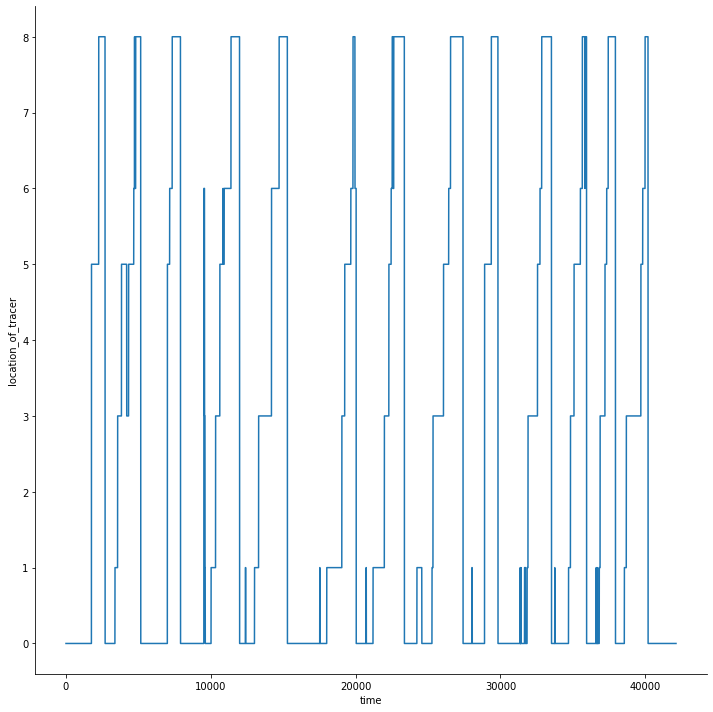

In [ ]:
sns.relplot(
    data=max_signal_df,
    x=max_signal_df.time,
    y="location_of_tracer",
    kind="line",
    height=10,
)
plt.show()

In [44]:
person_dict_list=time_analyse(max_signal_df)
print(person_dict_list)

[0, 199, 24204, 60979, 71806, 72175, 87126, 89770, 92447, 109985, 112891, 115042, 158408, 162908, 165111, 165151, 165208, 165301, 165317, 165743, 165810, 179594, 196149, 196155, 196169, 196238, 196287, 196293, 196480, 196488, 196502, 196534, 196542, 196558, 196564, 196568, 196576, 199472, 199483, 199494, 199675, 199699, 199744, 199748, 223323, 231931, 231941, 253280, 255357, 255382, 260945, 272581, 273713, 273727, 289335]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

[{1: 3.7266666666666577, 3: 4.346666666666669, 5: 9.948333333333343, 6: 2.941666666666697, 8: 2.820000000000012}, {1: 5.635000000000006, 3: 11.339999999999995, 5: 5.201666666666613, 6: 3.5416666666667878, 8: 3.404999999999867}, {1: 13.176666666666673, 3: 8.851666666666672, 5: 24.075, 6: 14.641666666666667, 8: 10.676666666666673}, {1: 1.531666666666691, 3: 4.171666666666715, 5: 9.913333333333322, 6: 7.236666666666618, 8: 0.09666666666665454}, {1: 1.945000000000012, 3: 3.8149999999999635, 5: 16.82499999999994, 6: 2.0033333333333454, 8: 13.526666666666642}, {1: 1.3733333333333575, 3: 2.6183333333333696, 5: 3.973333333333297, 6: 1.3283333333332845, 8: 20.81833333333349}, {1: 1.1933333333333092, 3: 1.8450000000000122, 5: 3.8816666666666912, 6: 1.7649999999999637, 8: 10.675}, {1: 15.375, 3: 3.101666666666703, 5: 2.009999999999976, 6: 1.0416666666666061, 8: 2.3766666666666425}]


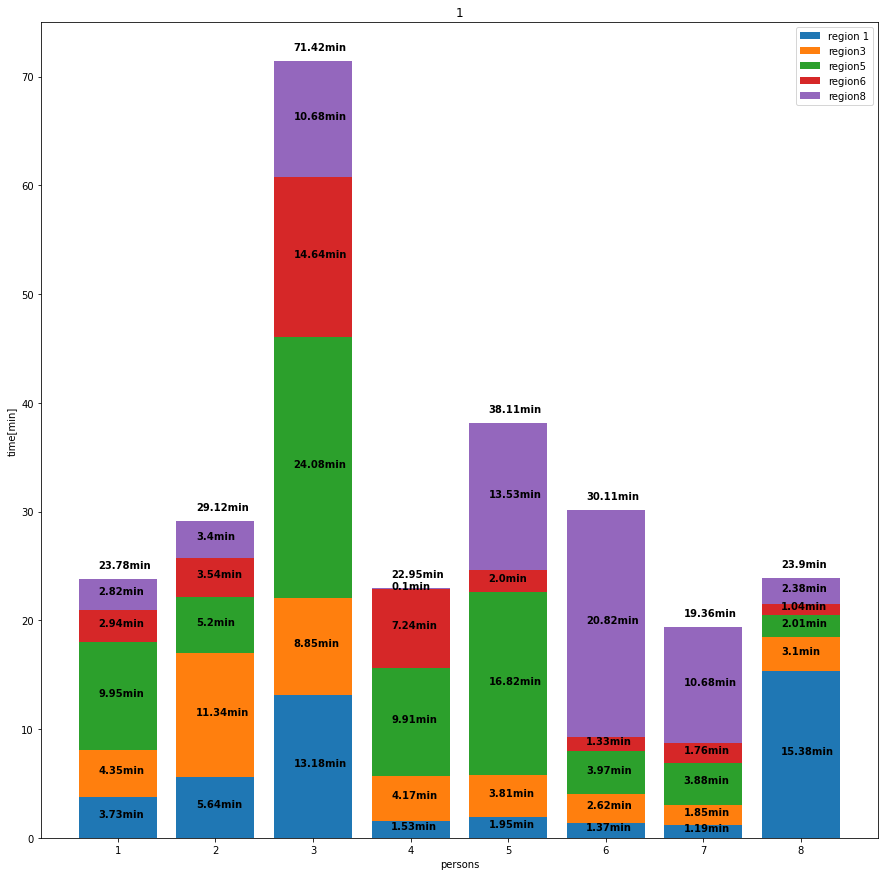

In [59]:
plot_time_analyse(person_dict_list,1)